<a href="https://colab.research.google.com/github/pouyarahmti/Pytorch-Deep-Learning-Bootcamp/blob/main/08_pytorch_paper_replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch Paper Replicaing

The goal of machine learning paper replicating is: turn a ML research paper into usable code.

In this notebook we are going to replicate Vision Transformer (ViT) architecture/paper with PyTorch: https://arxiv.org/abs/2010.11929

In [ ]:
import torch
import torchvision


print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

PyTorch version: 2.5.1+cu121
Torchvision version: 0.20.1+cu121


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1540/1540), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 4393 (delta 1459), reused 1408 (delta 1401), pack-reused 2853 (from 1)
Receiving objects: 100% (4393/4393), 650.73 MiB | 35.53 MiB/s, done.
Resolving deltas: 100% (2661/2661), done.
Updating files: 100% (248/248), done.


In [ ]:
# setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


## 1. Get Data

We are going to use ViT architecture on our food vision mini data (Pizza, steak, sushi)

In [ ]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [ ]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and Dataloaders

In [ ]:
from torchvision import transforms
from going_modular.going_modular import data_setup


# Image Size
IMG_SIZE = 224 # Comes from table 3 of ViT paper

# Transform
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

In [ ]:
# Batch Size
BATCH_SIZE = 32

# Create Dataloaders
train_dataloaders, test_dataloaders, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

len(train_dataloaders), len(test_dataloaders), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

In [ ]:
## 2.3 Visualiz a single image

image_batch, label_batch = next(iter(train_dataloaders))

# Get a single Image
img, label = image_batch[0], label_batch[0]

img.shape, label

(torch.Size([3, 224, 224]), tensor(2))

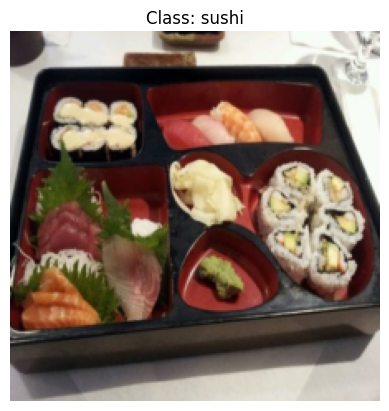

In [ ]:
# plot the image with matplotlib
plt.imshow(img.permute(1, 2, 0))
plt.title(f"Class: {class_names[label]}")
plt.axis(False)
plt.show()

## 3. Replication ViT Model

Looking at a whole machine learning research paper can be iدtimidating.

So in order to make it more understandable, we can break it down into smaller pieces:

* **Inputs** - What goes into the model? (in our case, image tensors)
* **Outputs** - What comes out of the model/layer/block? (in our case, we want the model to output image classification labels)
* **Layers** - Takes an input, manipulates it with a function (for example could be self-attention).
* **Blocks** - A collection of layers.
* **Model (or architecture)** - A collection of blocks.

### 3.1 ViT pieces of Puzzle

* Figure 1: Visualize an overview of the ViT architecture
* 4 Equations: math equations which define the function of each layer/block
* Table 1/3: Different hyperparmeters for the architecture/training
* Text




#### Figure 1

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/images/08-vit-paper-figure-1-architecture-overview.png)

* Embeddings = Learnable representation (initialized with random numbers and improve over time)

#### 4 Equations

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/images/08-vit-paper-four-equations.png)

#### Table 1

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/images/08-vit-paper-table-1.png)
